<a href="https://colab.research.google.com/github/josephine-dworkin/capstone-rbf-fd/blob/main/RBF_FD_works_better.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import math
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import cKDTree
from scipy.sparse import csr_matrix, eye, diags, identity
from scipy.sparse.linalg import spsolve, factorized, LinearOperator, onenormest
from numpy.linalg import solve, cond
from scipy.stats import norm

A: Initial parameters

In [51]:
K = 100 # strike price
T = 1 # time
r = 0.03
sigma = 0.15
M = 10 ** 6

S_min, S_max = 0.0, 400.0
N = 500 # number of nodes
m = 11 # stencil size
k = 7 # polyharmonic spline degree
p = 3 # degree of polynomial augmentation
dt = 1 / N
Nt = int(T / dt)

B: Node generation and clustering

In [52]:
def uniform_nodes(N, S_min, S_max):
  # generates a simple uniform grid between Smin and Smax.
  return np.linspace(S_min, S_max, N)

def halton_nodes(S_min, S_max, N, burnin=0):
  # generates a non-uniform grid
  from scipy.stats import qmc
  sampler = qmc.Halton(d=1, scramble=False)
  samples = sampler.random(n=N + burnin)
  halton_points = samples[burnin:, 0]
  # maps grid to correct domain between Smin and Smax
  S_nodes = S_min + (S_max - S_min) * halton_points
  S_nodes = np.asarray(S_nodes)
  S_nodes.sort()
  return S_nodes

def adapted_nodes(S_min, S_max, K, N, H=0.1):
  # generates sepcialised non-uniform nodes which are clustered around K by degree H
  K_hat = (K - S_min) / (S_max - S_min)
  z_min = np.arcsinh(-K_hat / H)
  z_max = np.arcsinh((1 - K_hat) / H)
  dz = (z_max - z_min) / N
  i = np.arange(N)
  z = z_min + i * dz
  # maps nodes in [0,1]
  x_hat = K_hat + H * np.sinh(z)
  # then maps to my actual computational domain between Smin and Smax
  S_nodes = S_min + (S_max - S_min) * x_hat
  return np.sort(S_nodes)

def clustered_strike_nodes(S_min, S_max, K, N, alpha=5.0):
  xi = np.linspace(0.0, 1.0, N)
  xi_K = (K - S_min) / (S_max - S_min)
  S = np.empty_like(xi)
  # Left of strike
  mask_left = xi <= xi_K
  S[mask_left] = (
      K
      - (K - S_min)
      * np.sinh(alpha * (xi_K - xi[mask_left]) / xi_K)
      / np.sinh(alpha)
  )
  # Right of strike
  mask_right = xi > xi_K
  S[mask_right] = (
      K
      + (S_max - K)
      * np.sinh(alpha * (xi[mask_right] - xi_K) / (1.0 - xi_K))
      / np.sinh(alpha)
  )
  # enforce exact endpoints
  S[0] = S_min
  S[-1] = S_max
  return S

S_nodes = adapted_nodes(S_min, S_max, K, N, H=0.1)

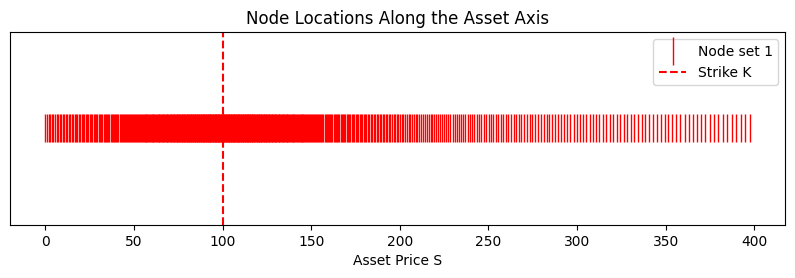

In [53]:
plt.figure(figsize=(10, 2.5))
plt.plot(S_nodes, np.zeros_like(S_nodes), '|', markersize=20, label='Node set 1', color='red')


plt.axvline(K, color='red', linestyle='--', label='Strike K')
plt.xlabel('Asset Price S')
plt.title('Node Locations Along the Asset Axis')
plt.yticks([])
plt.legend()
plt.show()

C: Stencil selection

In [54]:
def build_stencils(S_nodes, m):
  # builds stencils of dimension m around each node, consisting of the m-1 nearest nodes and itself
  S_nodes = np.asarray(S_nodes)
  tree = cKDTree(S_nodes[:, None])
  _, stencils = tree.query(S_nodes[:, None], k=m)
  return stencils

D: Local weight computation (RBF-FD per stencil)

In [25]:
def phs(r, k):
  # defines a polyharmonic spline for k odd
  return np.power(r, k)

def phs_d1(h, k):
  # defines the first derivative
  r = np.abs(h)
  return k * h * np.power(r, max(k - 2, 0))

def phs_d2(h, k):
  # defines the second derivative
  r = np.abs(h)
  return k * (k - 1) * np.power(r, max(k - 2, 0))

def poly_matrix_1D(x_local, k):
  # constructs a one-dimensional matrix with both derivatives
  return np.vstack([x_local ** d for d in range(k + 1)]).T


In [26]:
def build_augmented_matrix_and_rhs(x_local, x_center, k, p,
                                   enforce_constant=True, deriv_order=1):

  # Enforce_constant=False means I do not have an extra unknown/ constraint that enforces
  # the weights to sum to 0. I do not need this extra column because my polynomial augmentation
  # means the matrix includes the constant term "1" as the first column.
  m = x_local.size
  P = poly_matrix_1D(x_local, p)  # (m, p)
  p = P.shape[1]
  c = 1 if enforce_constant else 0

  # Phi matrix
  R = np.abs(x_local[:, None] - x_local[None, :])   # (m,m)
  Phi = phs(R, k)

  # Top-left block is Phi
  # Build top-right polynomial block and optional constant column
  if enforce_constant:
      P_aug = np.hstack([P, np.ones((m,1))])
  else:
      P_aug = P

  # Build bottom block
  bottom_left = P_aug.T
  bottom_right = np.zeros((p + c, p + c))
  # Assemble augmented matrix
  top = np.hstack([Phi, P_aug])
  bottom = np.hstack([bottom_left, bottom_right])
  A_aug = np.vstack([top, bottom])
  # Final augmented matrix has dimensions (m+p+c, m+p+c)

  # Build RHS
  # Top part: operator applied to phi centered at each x_local, evaluated at x_center
  h = x_center - x_local
  if deriv_order == 1:
      rhs_top = np.array([phs_d1(hj, k) for hj in h])
  elif deriv_order == 2:
      rhs_top = np.array([phs_d2(hj, k) for hj in h])
  else:
      raise ValueError("deriv_order must be 1 or 2")

  # Bottom part: derivative of polynomial basis at x_center
  rhs_poly = np.zeros(p + c)
  # For 1D: derivative of x^d is d * x^(d-1)
  if deriv_order == 1:
      for d in range(1, p):
          rhs_poly[d] = d * (x_center ** (d - 1))
      # if constant enforcement present, its RHS bottom entry is 0
  elif deriv_order == 2:
      for d in range(2, p):
          rhs_poly[d] = d * (d-1) * (x_center ** (d - 2))
  rhs = np.concatenate([rhs_top, rhs_poly])

  return A_aug, rhs, m, p, c

stencils = build_stencils(S_nodes, m)

Compute local weights

In [27]:
def compute_local_weights(x_local, x_center, k, p, enforce_constant=False,
                          deriv_order=1, regularize=1e-13):
  # solves the augmented matrix around each node to calculate weights, computing condition numbers of each of these matrices
  A_aug, rhs, m, p, c = build_augmented_matrix_and_rhs(
      x_local, x_center, k, p, enforce_constant=enforce_constant,
      deriv_order=deriv_order)

  # Tikhonov regularization
  if regularize:
      A_aug = A_aug.copy()
      A_aug[:m, :m] += np.eye(m) * regularize

  sol = solve(A_aug, rhs)
  weights = sol[:m]
  try:
    condA = cond(A_aug)
  except Exception:
    condA = np.inf
  return weights, condA

Scaling on each stencil

In [28]:
def compute_local_weights_scaled(x_local, x_center, k, p,
                                 enforce_constant=False,
                                 deriv_order=1,
                                 regularize=False):
  # local weights are scaled such that within each stencil, the distance of the node furthest from the central node is 1
  # distance from center
  r = np.abs(x_local - x_center)
  # scaling factor: max distance from center
  h = np.max(r)
  # scaled stencil inside [−1, 1]
  x_scaled = (x_local - x_center) / h
  x_center_scaled = 0.0   # set center to zero after scaling

  A_aug, rhs, m, p, c = build_augmented_matrix_and_rhs(
      x_scaled, x_center_scaled, k, p,
      enforce_constant=enforce_constant,
      deriv_order=deriv_order
  )
  # Tikhonov regularization
  if regularize:
        A_aug = A_aug.copy()
        A_aug[:m, :m] += np.eye(m) * regularize
  # solve system for scaled derivative
  sol = solve(A_aug, rhs)
  weights_scaled = sol[:m]
  # derivative rescales by h^{-d}
  scale_factor = h**(-deriv_order)
  weights = weights_scaled * scale_factor

  try:
      condA = cond(A_aug)
  except Exception:
      condA = np.inf

  return weights, condA

E: Assemble sparse global spatial operator

In [29]:
def build_global_derivative_matrices(S_nodes, m, k, p, sigma, r,
                                enforce_constant=False,
                                cond_warn=1e10):
  # local weight matrices assembled into global derivatice matrix which may then be solved for a linear operator
  # bc_nodes sets the indices to treat as Dirichlet rows (the boundary nodes)
  # for my Black-Scholes equations, i need a first derivative and a second derivative matrix
  N = S_nodes.size
  rows, cols, data_D1, data_D2 = [], [], [], []
  rowsA, colsA, dataA = [], [], []

  cond_list = np.zeros(N)

  stencils = build_stencils(S_nodes, m)

  for i in range(N):
    idx = stencils[i]
    x_local = S_nodes[idx]
    x_center = S_nodes[i]

    w1, cond1 = compute_local_weights_scaled(x_local, x_center,
                                      k, p, enforce_constant=enforce_constant, deriv_order=1)
    w2, cond2 = compute_local_weights_scaled(x_local, x_center,
                                      k, p, enforce_constant=enforce_constant, deriv_order=2)

    cond_list[i] = max(cond1, cond2)

    if cond_list[i] > cond_warn:
      print(f"stencil {[i]} cond ~ {cond_list[i]:.2e}")

    for local_j, j in enumerate(idx):
      # store D1 and D2 entries
      rows.append(i); cols.append(j)
      data_D1.append(w1[local_j])
      data_D2.append(w2[local_j])

  D1 = csr_matrix((data_D1, (rows, cols)), shape=(N, N))
  D2 = csr_matrix((data_D2, (rows, cols)), shape=(N, N))

  return D1.tocsr(), D2.tocsr(), stencils, cond_list

Construct the Black-Scholes operator separately

In [30]:
def construct_linear_operator(S_nodes, m, k, p, sigma, r, enforce_constant=False):
  # first derivative matrix, second derivative matrix, and final spatial linear operator carefully computed
  D1, D2, stencils, cond_local = build_global_derivative_matrices(S_nodes, m, k, p, sigma, r, enforce_constant=enforce_constant)
  N = len(S_nodes)
  S = S_nodes
  I = identity(N, format="csr")
  S_diag = diags(S)
  S_squared_diag = diags(S**2)

  L = (0.5 * sigma ** 2 * S_squared_diag @ D2 + r * S_diag @ D1 - r * I)

  return D1, D2, L, stencils, cond_local

Boundaries

In [31]:
def boundary_values_call_1d(S_nodes, t, T, r, K):
  # since pdes are on a potentially infinite domain, i must enforce the analytic solution at my boundaries
  # this function computes the analytic solutions at Smin and Smax
  S_max = S_nodes[-1]

  g_left = 0.0
  g_right = S_max - K * np.exp(-r * (T - t))

  return g_left, g_right

def enforce_dirichlet_rows(A, rhs, bc_idx, bc_vals):
  # and this one enforce them unto my linear operator
  A = A.tolil()
  for idx, g in zip(bc_idx, bc_vals):
    A.rows[idx] = [idx]
    A.data[idx] = [1.0]
    rhs[idx] = g

  return A.tocsr(), rhs

Condition number of golbal linear operator

In [32]:
from scipy.sparse.linalg import eigs

def cond_spectral(A, k=1):
  lam_max = eigs(A, k=k, which="LM", return_eigenvectors=False)
  lam_min = eigs(A, k=k, which="SM", return_eigenvectors=False)
  return abs(lam_max[0])/abs(lam_min[0])

Time Discretization using BDF-2

In [33]:
def solve_bdf2(
    S_nodes, m, k, p,
    sigma, r, K, T,
    enforce_constant=False,
    bc_nodes=(0, -1),
    cond_warn=1e10,
    verbose=True
    ):
  # Black-Scholes backward in time so I compute time discretization
  N = S_nodes.size
  dt = 1 / N
  Nt = int(np.ceil(T / dt))

  D1, D2, L, stencils, cond_local = construct_linear_operator(
      S_nodes, m, k, p, sigma, r, enforce_constant=enforce_constant)

  I = identity(N, format="csr")

  # terminal condition (payoff)
  V0_term = np.maximum(S_nodes - K, 0.0)

  # boundary indices
  bc_idx = [(b if b >= 0 else N + b) for b in bc_nodes]

  if verbose:
      print(f"BDF-2: Nt={Nt}, dt={dt} (Backward Euler startup)")

  # backward Euler for first time step:
  BE_left = (I / dt - L).tocsr()
  rhs_BE = V0_term / dt

  t1 = T - dt
  g1_left, g1_right = boundary_values_call_1d(S_nodes, t1, T, r, K)
  bc_vals1 = [g1_left, g1_right]

  BE_left, rhs_BE = enforce_dirichlet_rows(
      BE_left.copy(), rhs_BE, bc_idx, [g1_left, g1_right]
  )

  V_prev = V0_term.copy()   # V^0
  V_curr = spsolve(BE_left, rhs_BE)  # V^1

  # implementing BDF-2
  BDF2_left_base = (3.0 / (2.0 * dt)) * I - L
  BDF2_left_base = BDF2_left_base.tocsr()

  for n in range(1, Nt):
      t_next = T - (n + 1) * dt

      rhs = (
          (4.0 / (2.0 * dt)) * V_curr
          - (1.0 / (2.0 * dt)) * V_prev
      )

      g_left, g_right = boundary_values_call_1d(S_nodes, t_next, T, r, K)

      BDF2_left, rhs = enforce_dirichlet_rows(
          BDF2_left_base.copy(), rhs, bc_idx, [g_left, g_right]
      )

      V_next = spsolve(BDF2_left, rhs)

      V_prev[:] = V_curr
      V_curr[:] = V_next

  # solution at t = 0
  V0 = V_curr

  # solving for the Greeks
  Delta = D1 @ V0
  Gamma = D2 @ V0

  # Theta from PDE:  V_t = A V   →   Theta = -V_t
  Theta = -L @ V0

  # condition number estimate
"""must complete!!"""

  return {
      "V0": V0,
      "Delta": Delta,
      "Gamma": Gamma,
      "Theta": Theta,
      "cond_local": cond_local,
  }


In [34]:
solution = solve_bdf2(
            S_nodes, m, k, p,
            sigma, r, K, T,
            enforce_constant=False,
            bc_nodes=(0, -1),
            cond_warn=1e10,
            verbose=True)

V0 = solution["V0"]
delta_bdf = solution["Delta"]
gamma_bdf = solution["Gamma"]
theta_bdf = solution["Theta"]

BDF-2: Nt=500, dt=0.002 (Backward Euler startup)


H: Confervence tests and error analysis

Generating analytic solutions

In [35]:
def black_scholes_exact(S, K, T, t, r, sigma, option="call"):
    S = np.asarray(S, dtype=float)
    tau = np.maximum(T - t, 1e-14)  # avoid division by zero

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    if option == "call":
        V = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    elif option == "put":
        V = K * np.exp(-r * tau) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option must be 'call' or 'put'")

    return V

def delta_exact(S, K, T, t, r, sigma, option="call"):
    S = np.asarray(S, dtype=float)
    tau = np.maximum(T - t, 1e-14)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))

    if option == "call":
        return norm.cdf(d1)
    else:
        return norm.cdf(d1) - 1

def gamma_exact(S, K, T, t, r, sigma):
    S = np.asarray(S, dtype=float)
    tau = np.maximum(T - t, 1e-14)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))

    return norm.pdf(d1) / (S * sigma * np.sqrt(tau))

def theta_exact(S, K, T, t, r, sigma, option="call"):
    S = np.asarray(S, dtype=float)
    tau = np.maximum(T - t, 1e-14)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    term1 = - (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(tau))

    if option == "call":
        term2 = - r * K * np.exp(-r * tau) * norm.cdf(d2)
    else:
        term2 = + r * K * np.exp(-r * tau) * norm.cdf(-d2)

    return term1 + term2


Running for uniform nodes

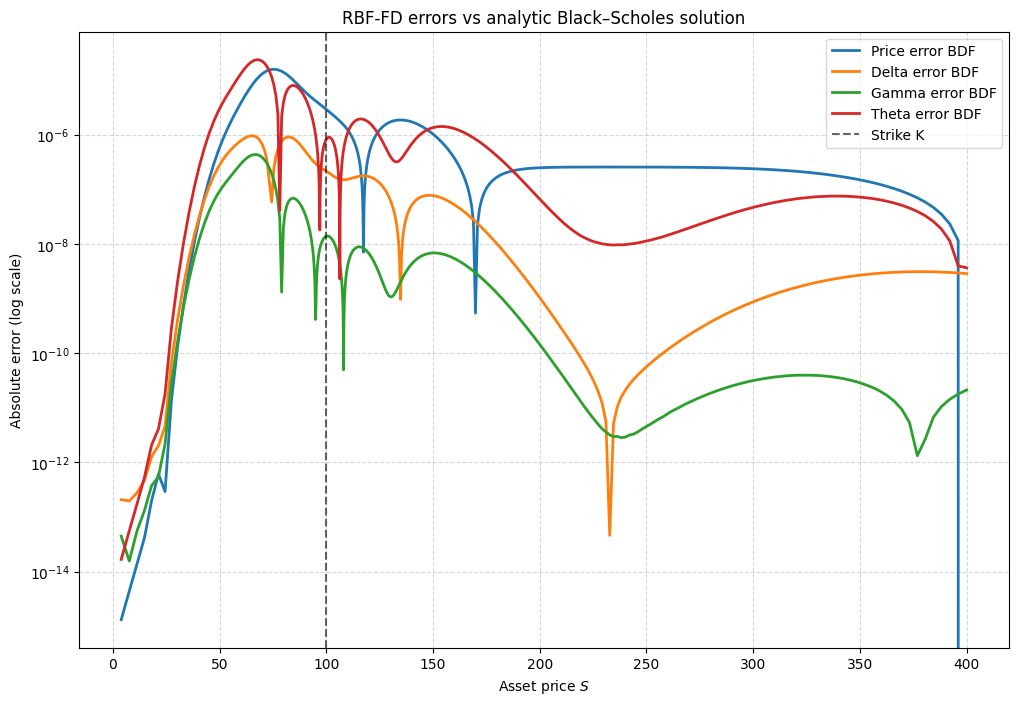

In [36]:
t_eval = 0.0

mask = S_nodes > 0

S_eval     = S_nodes[mask]
V_num      = V0[mask]
Delta_num  = delta_bdf[mask]
Gamma_num  = gamma_bdf[mask]
Theta_num  = theta_bdf[mask]

V_exact      = black_scholes_exact(S_eval, K, T, t_eval, r, sigma)
Delta_analytic  = delta_exact(S_eval, K, T, t_eval, r, sigma)
Gamma_analytic  = gamma_exact(S_eval, K, T, t_eval, r, sigma)
Theta_analytic  = theta_exact(S_eval, K, T, t_eval, r, sigma)

price_error_bdf     = np.abs(V_num - V_exact)
delta_error_bdf = np.abs(Delta_num - Delta_analytic)
gamma_error_bdf = np.abs(Gamma_num - Gamma_analytic)
theta_error_bdf = np.abs(Theta_num - Theta_analytic)

plt.figure(figsize=(12, 8))

plt.semilogy(S_eval, price_error_bdf, label="Price error BDF", linewidth=2)
plt.semilogy(S_eval, delta_error_bdf, label="Delta error BDF", linewidth=2)
plt.semilogy(S_eval, gamma_error_bdf, label="Gamma error BDF", linewidth=2)
plt.semilogy(S_eval, theta_error_bdf, label="Theta error BDF", linewidth=2)

plt.axvline(K, color="k", linestyle="--", alpha=0.6, label="Strike K")

plt.xlabel("Asset price $S$")
plt.ylabel("Absolute error (log scale)")
plt.title("RBF-FD errors vs analytic Black\u2013Scholes solution")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)

plt.show()

Condition numbers

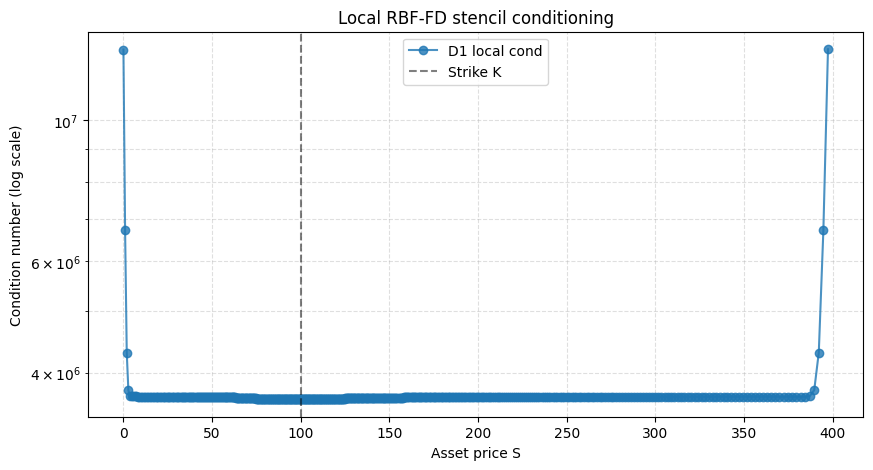

In [56]:
def collect_local_condition_numbers(S_nodes, stencils, k, p):
    N = S_nodes.size
    cond_d1 = np.zeros(N)
    cond_d2 = np.zeros(N)

    for i in range(N):
        idx = stencils[i]
        x_local = S_nodes[idx]
        x_center = S_nodes[i]

        _, cond1 = compute_local_weights_scaled(
            x_local, x_center, k, p, deriv_order=1
        )
        _, cond2 = compute_local_weights_scaled(
            x_local, x_center, k, p, deriv_order=2
        )

        cond_d1[i] = cond1
        cond_d2[i] = cond2

    return cond_d1, cond_d2

cond_d1, cond_d2 = collect_local_condition_numbers(S_nodes, stencils, k, p)

plt.figure(figsize=(10, 5))
plt.semilogy(S_nodes, cond_d1, 'o-', label="D1 local cond", alpha=0.8)
# plt.semilogy(S_nodes, cond_d2, 's-', label="D2 local cond", alpha=0.8)

plt.axvline(K, color='k', linestyle='--', alpha=0.5, label="Strike K")

plt.xlabel("Asset price S")
plt.ylabel("Condition number (log scale)")
plt.title("Local RBF-FD stencil conditioning")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()



Testing for various degrees of clustering:


Running H = 0.05


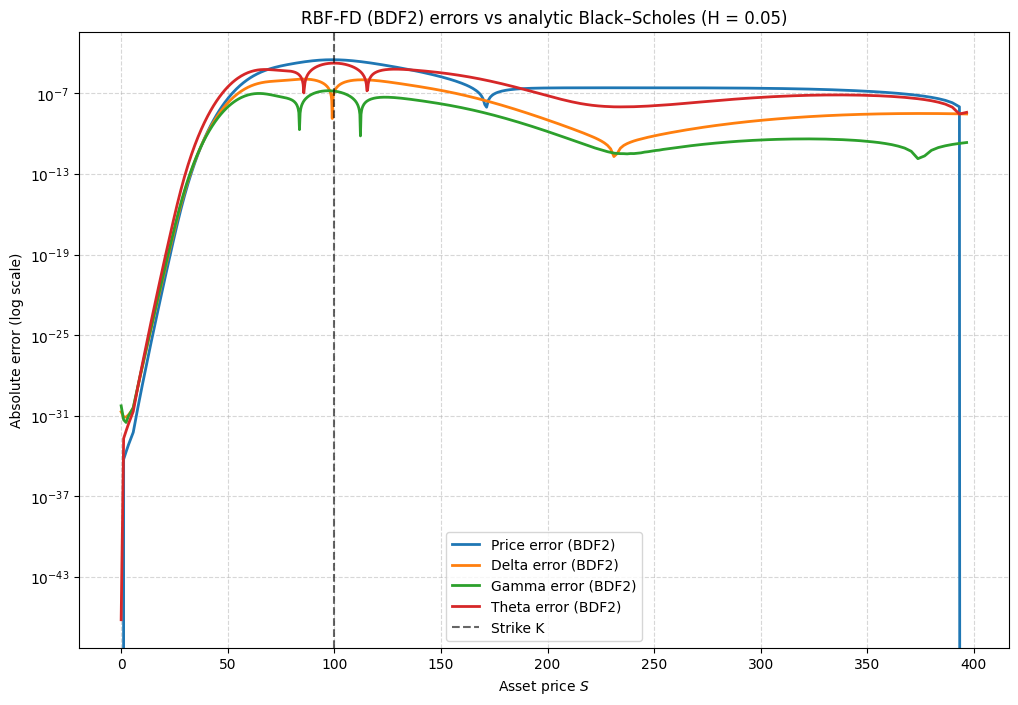


Running H = 0.1


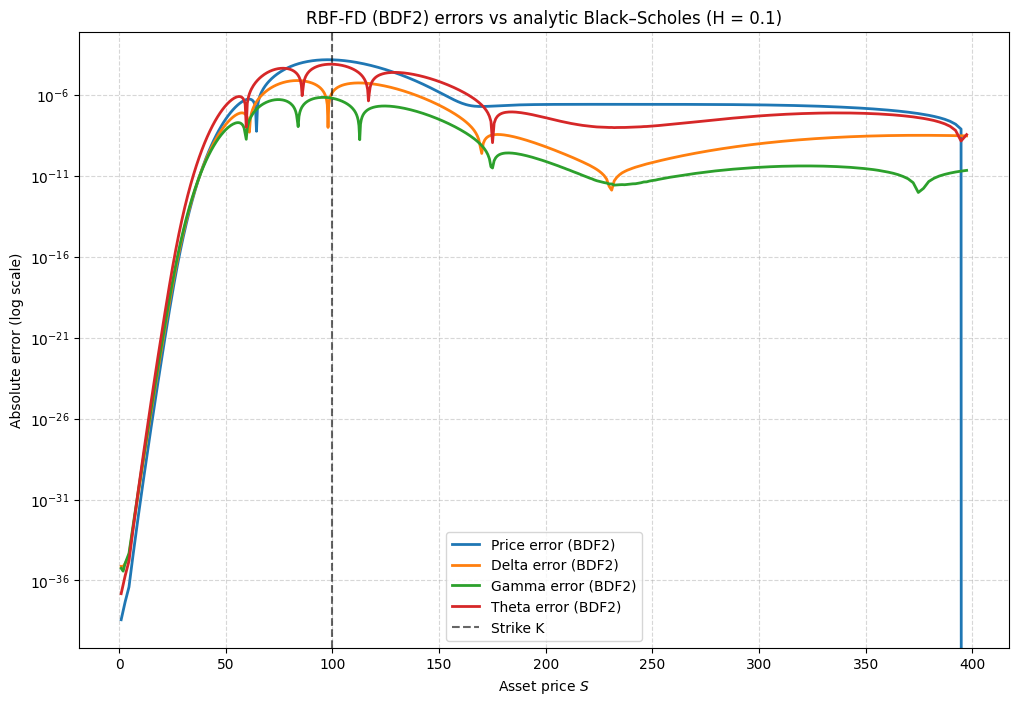


Running H = 0.2


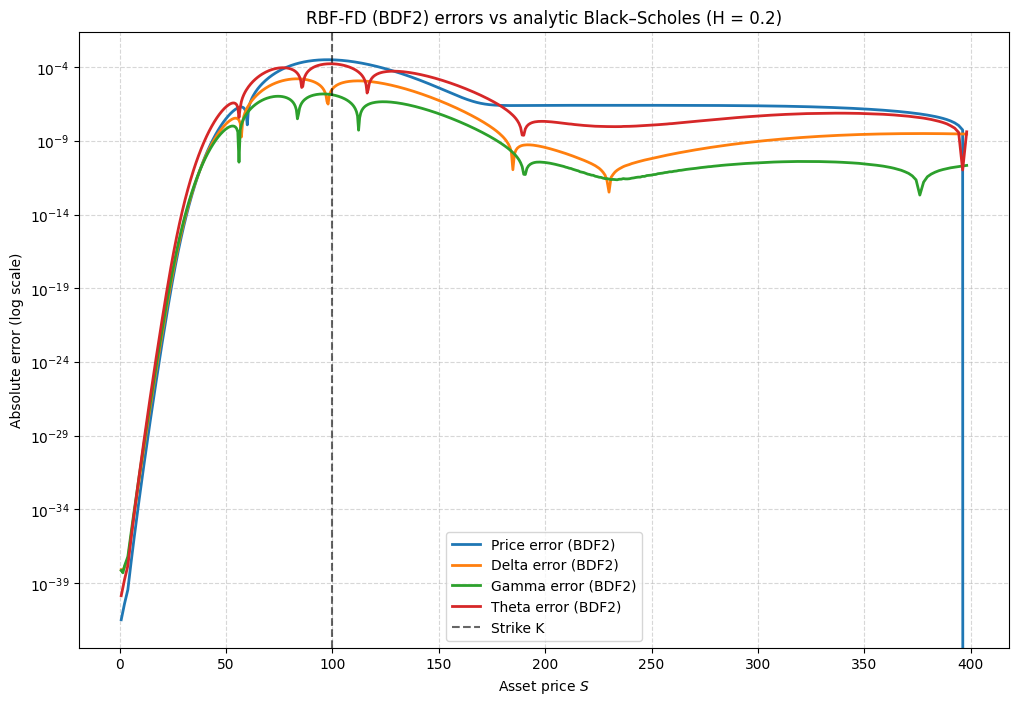

In [38]:
def run_experiment(
    *,
    H,
    node_params,
    solver_params,
    verbose=True
    ):
  # single function that executes entire RBF-FD method
  S_nodes = adapted_nodes(
      node_params["S_min"],
      node_params["S_max"],
      node_params["K"],
      node_params["N"],
      H=H
  )

  local_solver_params = dict(solver_params)
  local_stencils = build_stencils(S_nodes, m)

  results = solve_bdf2(
      S_nodes=S_nodes,
      verbose=verbose,
      **local_solver_params
  )

  results["H"] = H
  results["S_nodes"] = S_nodes

  return results


def plot_errors_bdf(
    results,
    *,
    K, T, r, sigma,
    S_min_plot=50.0,
    eps=1e-8,
    title_suffix=""
):
  S_nodes = results["S_nodes"]
  V0      = results["V0"]
  Delta   = results["Delta"]
  Gamma   = results["Gamma"]
  Theta   = results["Theta"]

  t_eval = 0.0

  mask = S_nodes > S_min_plot

  S_eval    = S_nodes[mask]
  V_num     = V0[mask]
  Delta_num = Delta[mask]
  Gamma_num = Gamma[mask]
  Theta_num = Theta[mask]

  V_exact = black_scholes_exact(
      S_eval, K, T, t_eval, r, sigma
  )
  Delta_exact = delta_exact(
      S_eval, K, T, t_eval, r, sigma
  )
  Gamma_exact = gamma_exact(
      S_eval, K, T, t_eval, r, sigma
  )
  Theta_exact = theta_exact(
      S_eval, K, T, t_eval, r, sigma
  )

  price_error = np.abs(V_num - V_exact)
  delta_error = np.abs(Delta_num - Delta_exact)
  gamma_error = np.abs(Gamma_num - Gamma_exact)
  theta_error = np.abs(Theta_num - Theta_exact)

  plt.figure(figsize=(12, 8))

  plt.semilogy(S_eval, price_error, label="Price error (BDF2)", lw=2)
  plt.semilogy(S_eval, delta_error, label="Delta error (BDF2)", lw=2)
  plt.semilogy(S_eval, gamma_error, label="Gamma error (BDF2)", lw=2)
  plt.semilogy(S_eval, theta_error, label="Theta error (BDF2)", lw=2)

  plt.axvline(K, color="k", ls="--", alpha=0.6, label="Strike K")

  plt.xlabel("Asset price $S$")
  plt.ylabel("Absolute error (log scale)")
  plt.title(
      "RBF-FD (BDF2) errors vs analytic Black–Scholes"
      + title_suffix
  )
  plt.legend()
  plt.grid(True, which="both", ls="--", alpha=0.5)
  plt.show()

  return price_error, delta_error, gamma_error, theta_error

node_params = dict(
    S_min=0.0,
    S_max=400.0,
    N=N,
    K=K
)

solver_params = dict(
    m=m,
    k=k,
    p=p,
    sigma=sigma,
    r=r,
    K=K,
    T=T,
    enforce_constant=False,
    bc_nodes=(0, -1),
)

H_values = [0.05, 0.1, 0.2]

all_results = []

for H in H_values:
    print(f"\nRunning H = {H}")

    res = run_experiment(
        H=H,
        node_params=node_params,
        solver_params=solver_params,
        verbose=False
    )

    all_results.append(res)

    plot_errors_bdf(
        res,
        K=K,
        T=T,
        r=r,
        sigma=sigma,
        S_min_plot=0.0,
        title_suffix=f" (H = {H})"
    )


In [57]:
H_values = [0.025, 0.05, 0.1, 0.2]

results_all = []

for H in H_values:
    print(f"\nRunning H = {H}")
    res = run_experiment(
        H=H,
        node_params=node_params,
        solver_params=solver_params,
        verbose=False
    )
    results_all.append(res)

df = pd.DataFrame({
    "H": [r["H"] for r in results_all],
    "cond_max": [float(np.max(r["cond_local"])) for r in results_all],
    "cond_mean": [float(np.mean(r["cond_local"])) for r in results_all]
})

df


Running H = 0.025

Running H = 0.05

Running H = 0.1

Running H = 0.2


KeyboardInterrupt: 

In [ ]:
summary_rows = []

for H in H_values:
    print(f"\nRunning H = {H}")

    res = run_experiment(
        H=H,
        node_params=node_params,
        solver_params=solver_params,
        verbose=False
    )

    S_nodes = res["S_nodes"]
    V0      = res["V0"]
    Delta   = res["Delta"]
    Gamma   = res["Gamma"]
    Theta   = res["Theta"]

    t_eval = 0.0

    V_exact     = black_scholes_exact(S_nodes, K, T, t_eval, r, sigma)
    Delta_exact = delta_exact(S_nodes, K, T, t_eval, r, sigma)
    Gamma_exact = gamma_exact(S_nodes, K, T, t_eval, r, sigma)
    Theta_exact = theta_exact(S_nodes, K, T, t_eval, r, sigma)

    price_error = np.abs(V0 - V_exact)
    delta_error = np.abs(Delta - Delta_exact)
    gamma_error = np.abs(Gamma - Gamma_exact)
    theta_error = np.abs(Theta - Theta_exact)

    summary_rows.append({
        "H": H,
        "price_mean": float(np.mean(price_error)),
        "delta_mean": float(np.mean(delta_error)),
        "gamma_mean": float(np.mean(gamma_error)),
        "theta_mean": float(np.mean(theta_error)),
        "cond_median": float(np.median(res["cond_local"]))
    })

df_H = pd.DataFrame(summary_rows)
df_H


In [ ]:
N_values = [500, 1000, 2000, 4000]

summary_rows_N = []

for N in N_values:
    print(f"\nRunning N = {N}")

    node_params["N"] = N

    res = run_experiment(
        H=0.1,   # fix H while testing N
        node_params=node_params,
        solver_params=solver_params,
        verbose=False
    )

    S_nodes = res["S_nodes"]
    V0      = res["V0"]
    Delta   = res["Delta"]
    Gamma   = res["Gamma"]
    Theta   = res["Theta"]

    # eps = 1e-8
    # t_eval = T - eps
    t_eval = 0.0

    V_exact     = black_scholes_exact(S_nodes, K, T, t_eval, r, sigma)
    Delta_exact = delta_exact(S_nodes, K, T, t_eval, r, sigma)
    Gamma_exact = gamma_exact(S_nodes, K, T, t_eval, r, sigma)
    Theta_exact = theta_exact(S_nodes, K, T, t_eval, r, sigma)

    price_error = np.abs(V0 - V_exact)

    summary_rows_N.append({
        "N": N,
        "price_Linf": float(np.max(price_error)),
        "price_L2": float(np.sqrt(np.mean(price_error**2))),
        "cond_max": float(np.max(res["cond_local"])),
        "cond_median": float(np.median(res["cond_local"]))
    })

df_N = pd.DataFrame(summary_rows_N)

# --- compute empirical convergence rate ---
df_N["rate_Linf"] = np.nan
df_N["rate_L2"] = np.nan

for i in range(1, len(df_N)):
    df_N.loc[i, "rate_Linf"] = np.log(
        df_N.loc[i-1, "price_Linf"] / df_N.loc[i, "price_Linf"]
    ) / np.log(2)

    df_N.loc[i, "rate_L2"] = np.log(
        df_N.loc[i-1, "price_L2"] / df_N.loc[i, "price_L2"]
    ) / np.log(2)

df_N



Running N = 500


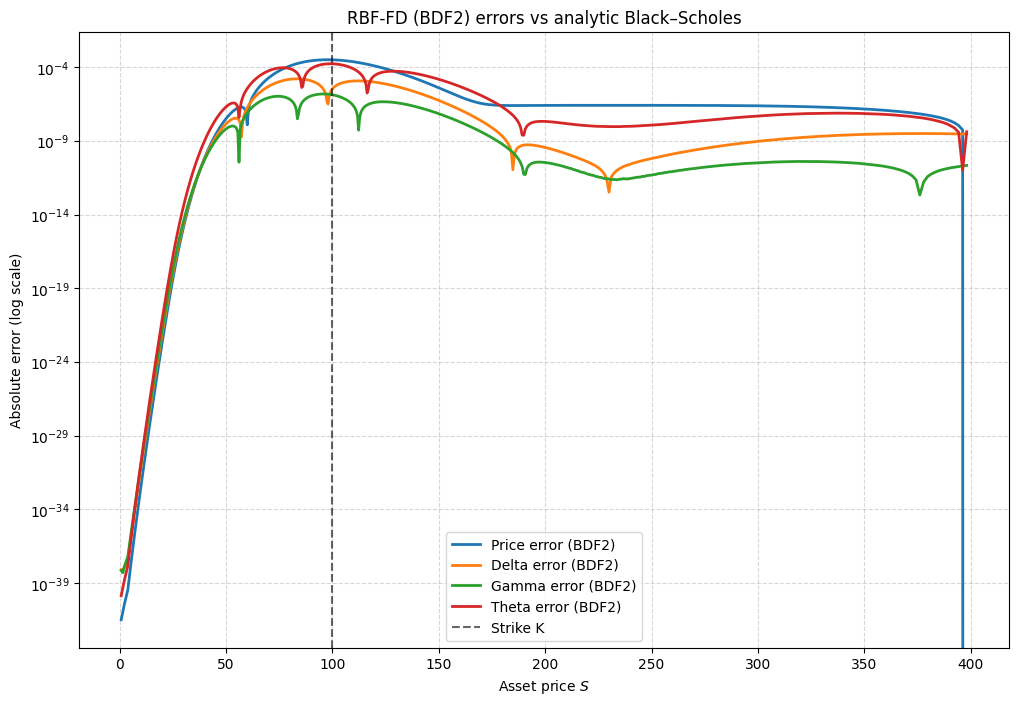

Running N = 1000


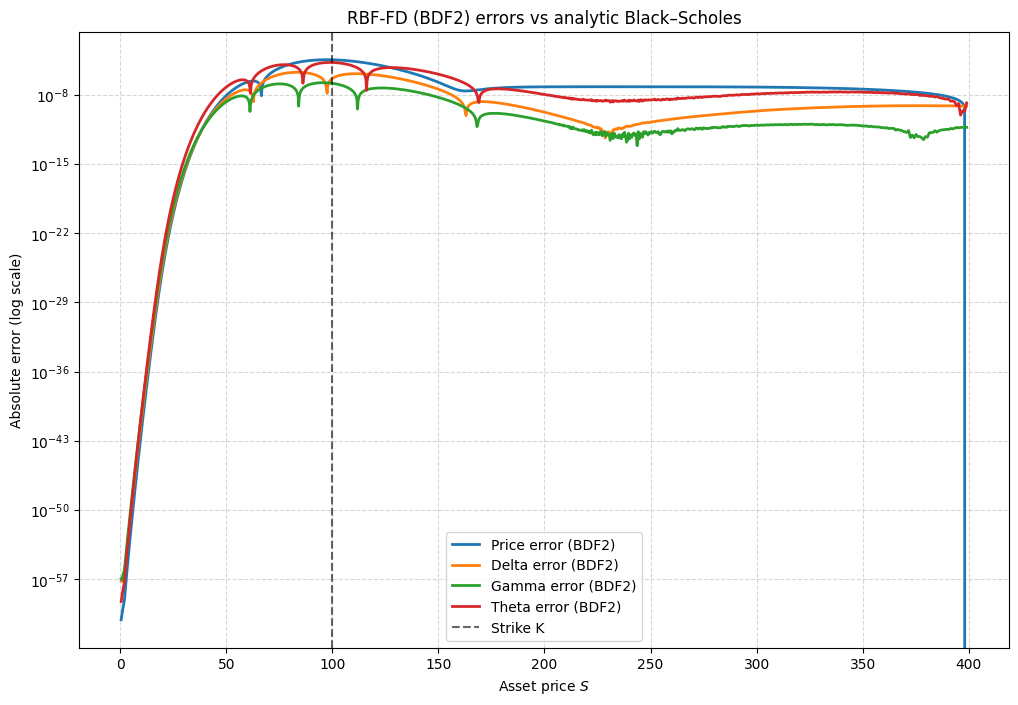

Running N = 2000


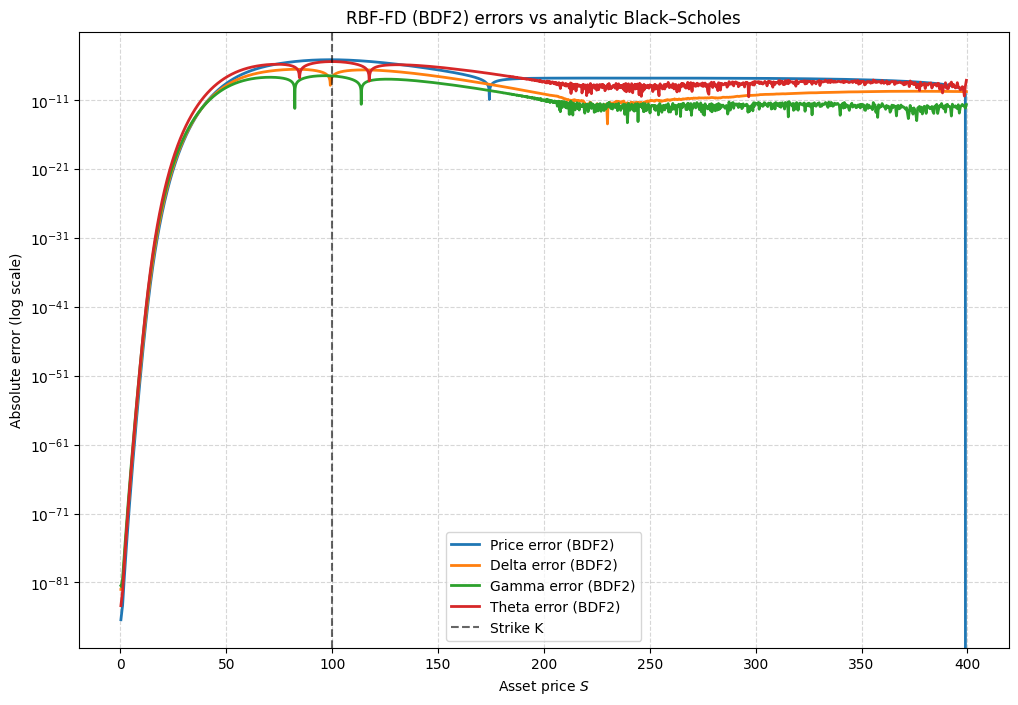

Running N = 4000


In [ ]:
N_values = [500, 1000, 2000, 4000]

rows = []

for N in N_values:

    print(f"Running N = {N}")

    node_params["N"] = N

    res = run_experiment(
        H=0.2,
        node_params=node_params,
        solver_params=solver_params,
        verbose=False
    )

    price_error, delta_error, gamma_error, theta_error = plot_errors_bdf(
        res,
        K=K,
        T=T,
        r=r,
        sigma=sigma,
        S_min_plot=0.0,
        title_suffix=""
    )

    # exclude boundaries
    price_Linf = np.max(price_error[1:-1])
    price_L2   = np.sqrt(np.mean(price_error[1:-1]**2))

    rows.append({
        "N": N,
        "price_Linf": price_Linf,
        "price_L2": price_L2,
        "cond_max": float(np.max(res["cond_local"])),
        "cond_median": float(np.median(res["cond_local"]))
    })

df_conv = pd.DataFrame(rows)

# compute convergence rates
df_conv["rate_Linf"] = np.log2(df_conv["price_Linf"].shift(1) / df_conv["price_Linf"])
df_conv["rate_L2"]   = np.log2(df_conv["price_L2"].shift(1) / df_conv["price_L2"])

df_conv


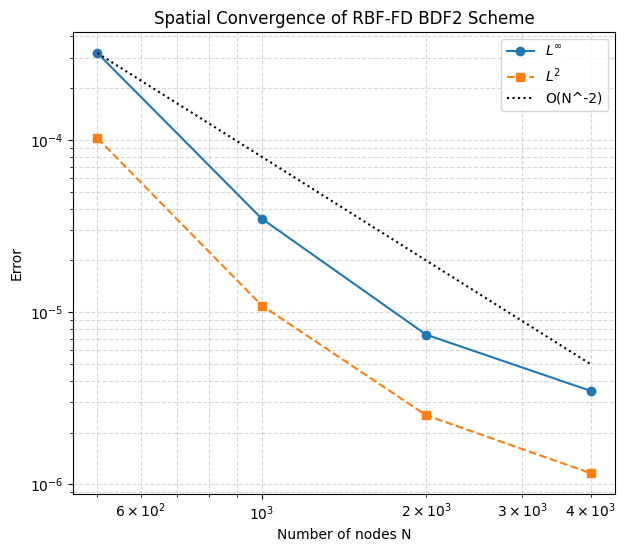

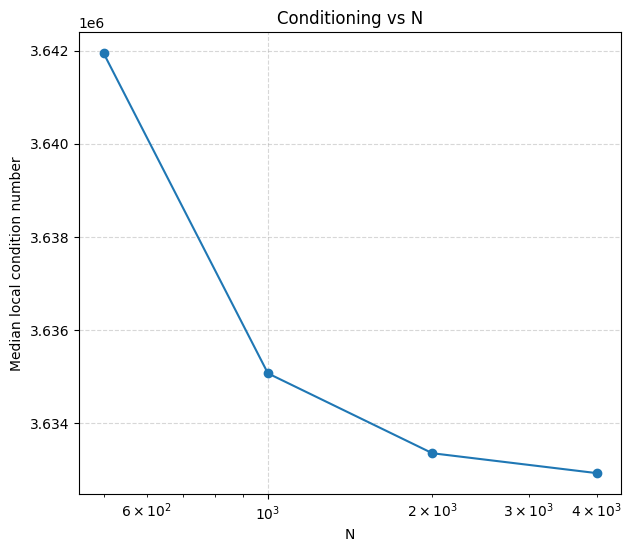

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))

plt.loglog(df_conv["N"], df_conv["price_Linf"], 'o-', label=r"$L^\infty$")
plt.loglog(df_conv["N"], df_conv["price_L2"], 's--', label=r"$L^2$")

# reference slope 2
N_ref = np.array(df_conv["N"])
ref_line = df_conv["price_Linf"].iloc[0] * (N_ref[0]/N_ref)**2
plt.loglog(N_ref, ref_line, 'k:', label="O(N^-2)")

plt.xlabel("Number of nodes N")
plt.ylabel("Error")
plt.title("Spatial Convergence of RBF-FD BDF2 Scheme")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()

plt.figure(figsize=(7,6))
plt.semilogx(df_conv["N"], df_conv["cond_median"], 'o-')
plt.xlabel("N")
plt.ylabel("Median local condition number")
plt.title("Conditioning vs N")
plt.grid(True, ls="--", alpha=0.5)
plt.show()


Convergence around the strike price: The payoof kink is at S=K, so the solution is the least smooth here. I conduct a localized convergence study to explore behaviour around S=K

I want a visualization of accuracy/ convergence for fixed N, various H, and also uniform and halton nodes